In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import false_discovery_control, ttest_ind
from riskyneuroarousal.utils.load_data import load_behavioral_data, load_pupil_data, load_ddm_results
%load_ext rpy2.ipython

How is the baseline pupil size related to Response Time?
Tonic Pupil size is associated with attention. 

In [2]:
behavior = load_behavioral_data(min_RT = 0.2)
pupil_data = load_pupil_data().groupby(["sub", "trial"])["baseline"].mean().reset_index()
data = pupil_data.merge(behavior, on=["sub", "trial"])
cond_sub = data[["sub", "condition"]].drop_duplicates()
pupil_data = pupil_data.merge(cond_sub, on="sub")
ddm_results = load_ddm_results().query("model_ID == 1")

In [3]:
data["uncertain"] = data["response_int"].apply(lambda x: "yes" if x == 2 or x == 3 else "no")

In [4]:
%%R -i data
library(lme4)
library(lmerTest)
library(broom.mixed)

Loading required package: Matrix

Attaching package: ‘lmerTest’

The following object is masked from ‘package:lme4’:

    lmer

The following object is masked from ‘package:stats’:

    step



In [29]:
%%R -o results
model1 <- lmer(RT ~ condition*gain + condition*loss + condition*uncertain + condition*baseline + (1|sub) + (-1 + baseline | sub), data=data)
results <- tidy(model1, effects="fixed", conf.int=TRUE)

In [30]:
results["p.value"] = false_discovery_control(results["p.value"], method = "by")

In [31]:
results

,effect,term,estimate,std.error,statistic,df,p.value,conf.low,conf.high
1,fixed,(Intercept),1.448167,0.058272,24.851953,71.977908,6.939702e-36,1.332004,1.564330
2,fixed,conditionequalRange,-0.114120,0.083210,-1.371476,72.120778,5.678249e-01,-0.279991,0.051751
3,fixed,gain,-0.002949,0.000617,-4.780832,13906.050443,1.033099e-05,-0.004158,-0.001740
4,fixed,loss,0.012099,0.001234,9.802913,13904.065705,1.264208e-21,0.009680,0.014519
5,fixed,uncertainyes,0.435580,0.012685,34.339427,13935.510854,1.121280e-246,0.410717,0.460444
6,fixed,baseline,-0.021768,0.008429,-2.582473,52.528141,6.167436e-02,-0.038679,-0.004858
7,fixed,conditionequalRange:gain,0.002124,0.001385,1.533967,13919.357732,4.578726e-01,-0.000590,0.004838
8,fixed,conditionequalRange:loss,-0.003001,0.001750,-1.714942,13911.965969,3.614271e-01,-0.006432,0.000429
9,fixed,conditionequalRange:uncertainyes,-0.168440,0.017842,-9.440548,13949.044438,3.138889e-20,-0.203413,-0.133467
10,fixed,conditionequalRange:baseline,-0.011849,0.012042,-0.983977,52.728688,9.654471e-01,-0.036004,0.012307


In [23]:
%%R -o results_individual
modelIndifference <- lmer(RT ~ gain + loss + uncertain + baseline + (1|sub) + (-1 + baseline | sub), data=data[data$condition == 'equalIndifference', ])
modelRange <- lmer(RT ~ gain + loss + uncertain + baseline + (1|sub) + (-1 + baseline | sub), data=data[data$condition == 'equalRange', ])
resultsIndifference <- tidy(modelIndifference, effects = "fixed", conf.int = TRUE, conf.level = 0.95) 
resultsRange <- tidy(modelRange, effects = "fixed", conf.int = TRUE, conf.level = 0.95)
resultsIndifference$condition <- 'equalIndifference'
resultsRange$condition <- 'equalRange'
results_individual <- rbind(resultsIndifference, resultsRange)

In [ ]:
results_individual["p.value"] = false_discovery_control(results_individual["p.value"], method = "by")

In [27]:
results_individual

,effect,term,estimate,std.error,statistic,df,p.value,conf.low,conf.high,condition
1,fixed,(Intercept),1.448238,0.057670,25.112395,37.559413,4.316554e-24,1.331445,1.565030,equalIndifference
2,fixed,gain,-0.002941,0.000632,-4.655267,7082.172759,1.378514e-05,-0.004179,-0.001702,equalIndifference
3,fixed,loss,0.012111,0.001264,9.580677,7081.017855,7.633664e-21,0.009633,0.014589,equalIndifference
4,fixed,uncertainyes,0.435447,0.012990,33.521641,7097.845762,2.280043e-227,0.409982,0.460911,equalIndifference
5,fixed,baseline,-0.021841,0.007473,-2.922568,26.228102,2.297579e-02,-0.037196,-0.006486,equalIndifference
6,fixed,(Intercept),1.333730,0.060014,22.223555,34.645101,3.217552e-21,1.211850,1.455610,equalRange
7,fixed,gain,-0.000819,0.001208,-0.678430,6832.344777,1.000000e+00,-0.003187,0.001548,equalRange
8,fixed,loss,0.009103,0.001209,7.529915,6830.410456,2.797710e-13,0.006733,0.011472,equalRange
9,fixed,uncertainyes,0.267145,0.012227,21.848802,6850.005037,3.425775e-101,0.243177,0.291114,equalRange
10,fixed,baseline,-0.033695,0.009479,-3.554521,26.166505,5.369355e-03,-0.053174,-0.014216,equalRange


In [15]:
data_up = results_individual.copy()
data_down = results_individual.copy()
data_up["estimate"] = data_up["conf.high"]
data_down["estimate"] = data_down["conf.low"]
data = pd.concat([data_up, data_down])

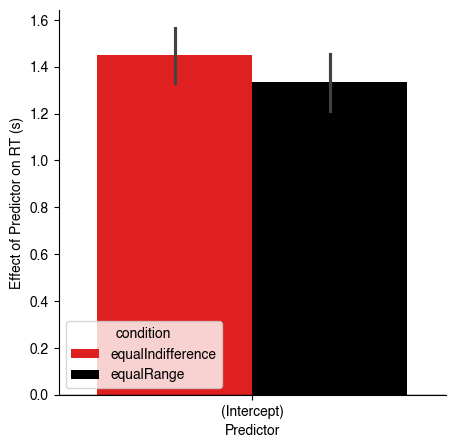

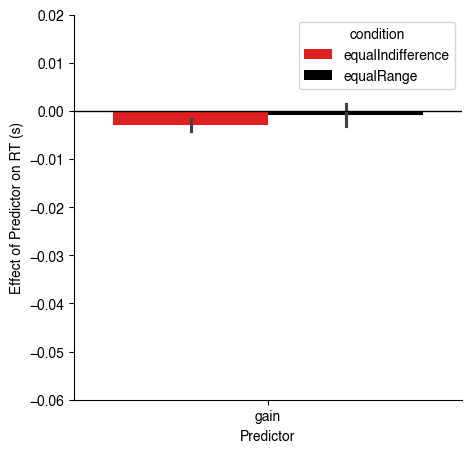

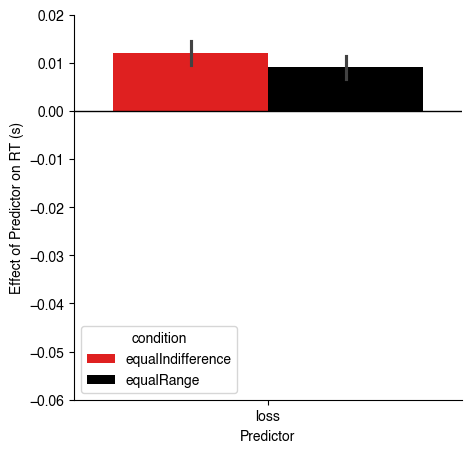

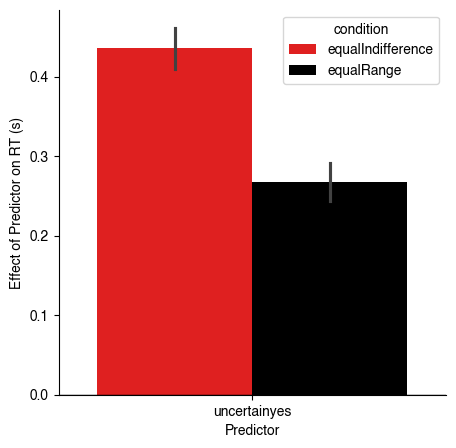

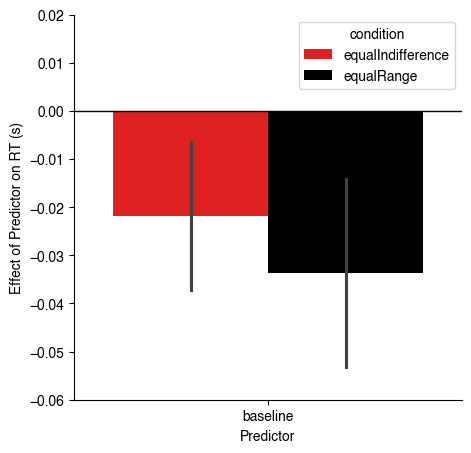

In [22]:
# Set the figure size
custom_palette = {"equalIndifference": "red", "equalRange": "black"}
for term in data["term"].unique():
    data_term = data.query(f"term == '{term}'")
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.rcParams["font.family"] = "Helvetica"
    sns.barplot(x="term", y="estimate", hue="condition", data=data_term, palette=custom_palette,)
    plt.axhline(0, color="black", linewidth=1)
    # remove top and right spines
    sns.despine(top=True, right=True)
    # X and Y labels
    plt.xlabel("Predictor")
    plt.ylabel("Effect of Predictor on RT (s)")
    if term == "gain" or term == "loss" or term == "baseline":
        plt.ylim(-0.06, 0.02)
    # Rename the xticks
    # plt.xticks([0, 1, 2, 3], ["Gain", "Loss", "Uncertain", "Pupil Baseline"])
    plt.show()

In [32]:
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

In [35]:
mean_baseline = pupil_data.groupby(["sub", "condition"])["baseline"].mean().reset_index()

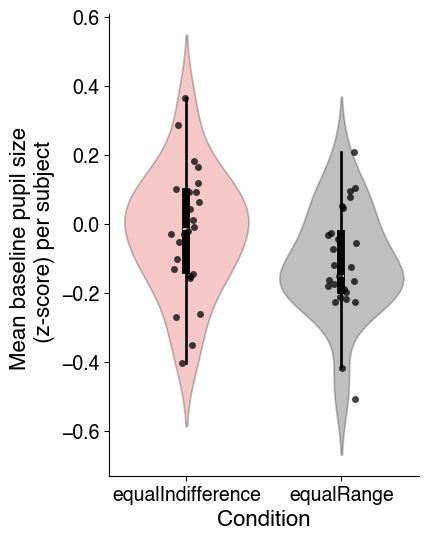

In [36]:
fig, ax = plt.subplots(figsize=(4, 6))
sns.violinplot(data=mean_baseline, x="condition", y="baseline", hue = "condition",  palette=custom_palette, alpha = 0.25)
sns.stripplot(data=mean_baseline, x="condition", y="baseline", color="black", alpha=0.75)
plt.xlabel("Condition", fontsize=16)
plt.ylabel("Mean baseline pupil size \n (z-score) per subject", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# Remove top and right spines
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.show()

In [37]:
ttest_ind(mean_baseline.query("condition == 'equalIndifference'")["baseline"], mean_baseline.query("condition == 'equalRange'")["baseline"])

TtestResult(statistic=np.float64(2.0157284834127243), pvalue=np.float64(0.04891080132348814), df=np.float64(53.0))

In [38]:
cohend(mean_baseline.query("condition == 'equalIndifference'")["baseline"], mean_baseline.query("condition == 'equalRange'")["baseline"])

np.float64(0.5436914202906995)

In [65]:
ddm_results = ddm_results.merge(mean_baseline, on=["sub"])

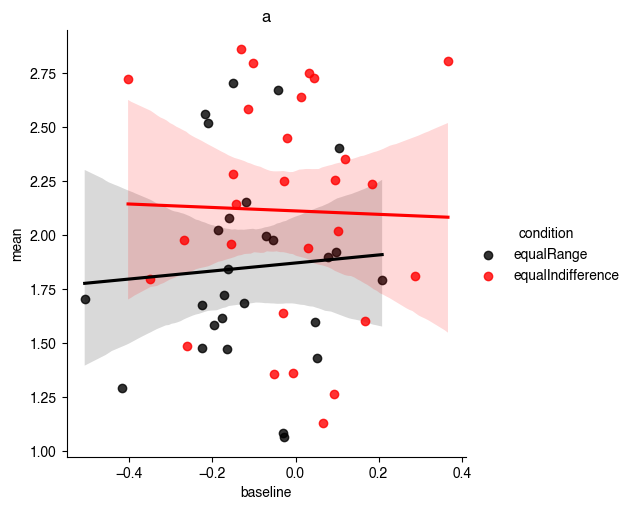

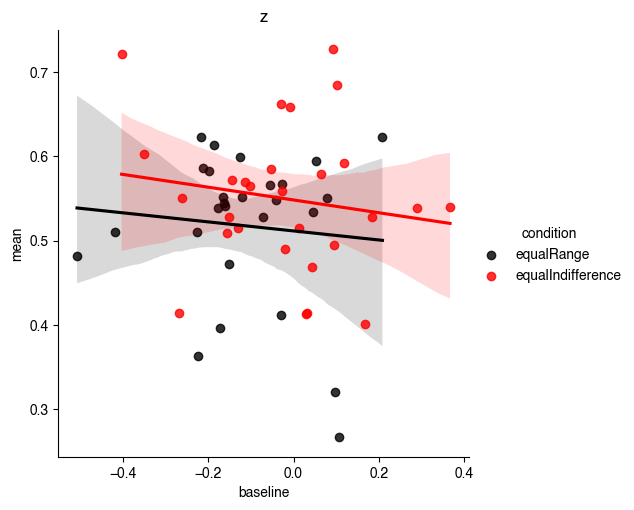

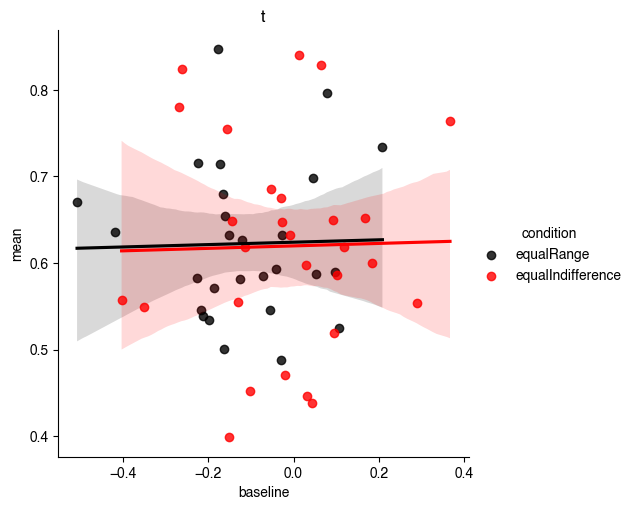

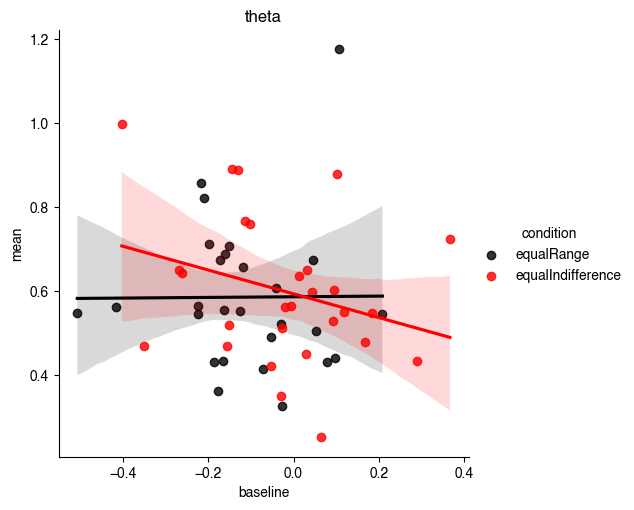

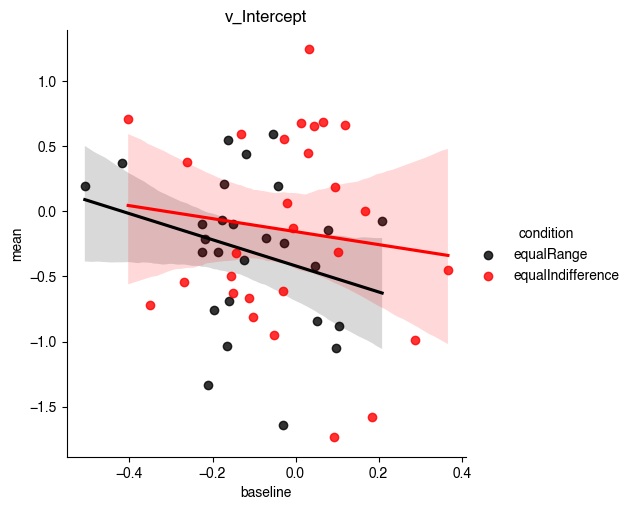

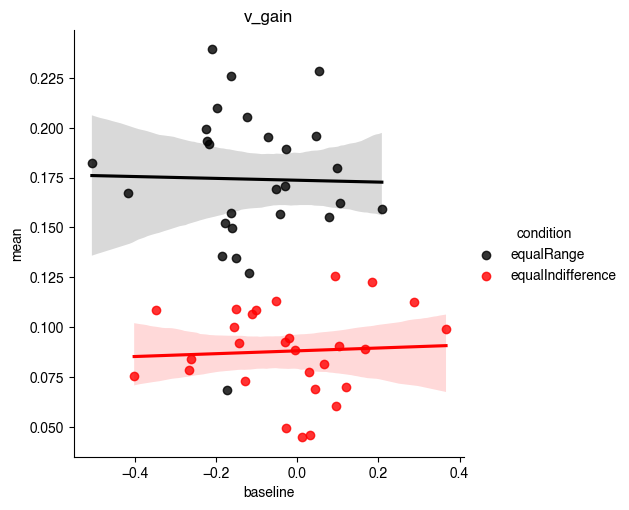

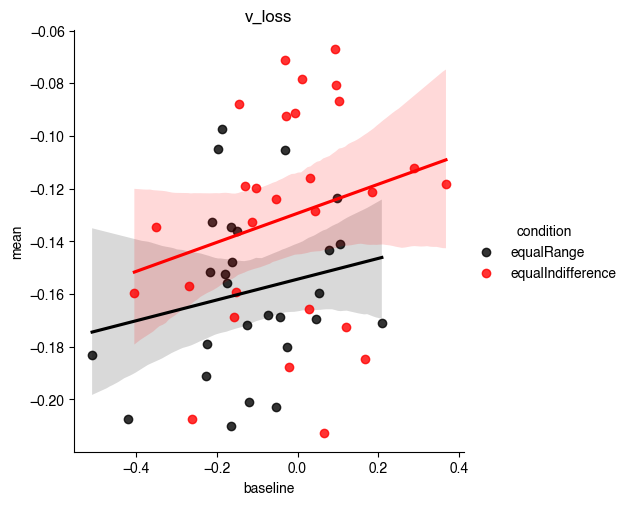

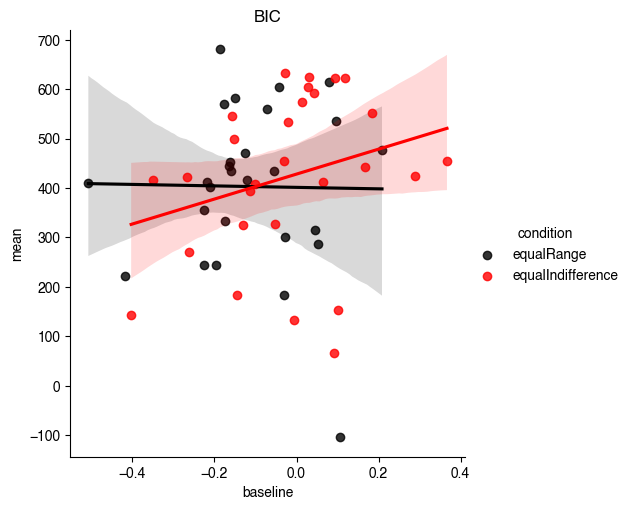

In [70]:
for param in ddm_results["param_name"].unique():
    sns.lmplot(x="baseline", y="mean", hue="condition", data=ddm_results.query(f"param_name == '{param}'"), palette=custom_palette)
    plt.title(param)